# OMPL code example

Given and empty 2D space from (-10, -10) to (10, 10) with 2 obstacles:
* $O_1$ goes from (-10, -7.5) to (5, -2.5)
* $O_2$ goes from (-5, 2.5) to (10, 7.5)

Plan a path from (-8, -8) to (8, 8)

In [1]:
# Define a list of rectangular obstacles defined as tuples containing: (x_min, y_min, x_max, y_max)
obstacles = [(-10, -7.5, 5, -2.5), (-5, 2.5, 10, 7.5)]

# Return True if free space and false if occupied (i.e., state is inside an obstacle)
def isStateValid(state):
    # Use the check_collision object to check if a state is valid or not
    for o in obstacles:
        if (state[0] >= o[0] and state[0]<= o[2]) and (state[1] >= o[1] and state[1]<= o[3]):
            # state inside an obstacle
            return False
    return True

In [129]:
from ompl import base as ob
from ompl import geometric as og

def plan(bound_low, bound_high, start_position, goal_position, time):
    # create an SE2 state space
    space = ob.RealVectorStateSpace(2)

    # Set the bounds of space to be in low to high.
    space.setBounds(bound_low, bound_high)

    # When performing discrete validation of motions, the length of the longest segment 
    # that does not require state validation needs to be specified. 
    # This function sets this length as a fraction of the space's maximum extent. 
    # The call is passed to all contained subspaces.
    # space.setLongestValidSegmentFraction(0.01) 

    # construct an instance of space information from this state space
    si = ob.SpaceInformation(space)
    
    # set state validity checking for this space
    si.setStateValidityChecker(ob.StateValidityCheckerFn(isStateValid))

    # create a start state
    start = ob.State(space)
    start[0] = start_position[0]
    start[1] = start_position[1]
    
    # create a goal state
    goal = ob.State(space)
    goal[0] = goal_position[0]
    goal[1] = goal_position[1]

    # create a problem instance
    pdef = ob.ProblemDefinition(si)
    
    # set the start and goal states
    pdef.setStartAndGoalStates(start, goal)
    
    # Create the optimization objective. Here it is to optimize the path lenght
    pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))

    # Construct the optimal planner. An RRT* planner is used.
    optimizingPlanner = og.RRTstar(si)
    # optimizingPlanner = og.RRTConnect(si)
    # optimizingPlanner = og.RRT(si)
    
    # it represents the maximum length of a motion to be added in the tree of motions.
    # optimizingPlanner.setRange(2.0)
    
    # In the process of randomly selecting states in the state space to attempt to go towards, 
    # the algorithm may in fact choose the actual goal state, if it knows it, with some probability. 
    # This probability is a real number between 0.0 and 1.0; 
    # its value should usually be around 0.05 and should not be too large. 
    # It is probably a good idea to use the default value.
    # optimizingPlanner.setGoalBias(0.2)

    # Set the problem instance for our planner to solve and call setup
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(time)
    
    # Get planner data
    pd = ob.PlannerData(si)
    optimizingPlanner.getPlannerData(pd)
    
    if solved:
        # get the path and transform it to a list
        path = pdef.getSolutionPath()
        # print("Found solution:\n%s" % path)
        ret = []
        for i in path.getStates():
            ret.append((i[0], i[1]))
    else:
        print("No solution found")
    return ret, pd, pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 52.18 in 188 iterations (87 vertices in the graph)
cost: Info:    RRTstar: Created 93 new states. Checked 4371 rewire options. 1 goal states in tree. Final solution cost 52.181
 52.1810132065733


(-10, 10)

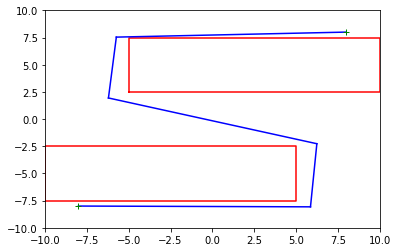

In [142]:
from matplotlib import pyplot as plt 
start = (-8, -8)
goal = (8, 8)
path, pd, cost = plan(-10, 10, start, goal, 0.1)
print("cost: ", cost)
# Plot obstacles
for o in obstacles:
    plt.plot([o[0], o[2], o[2], o[0], o[0]], [o[1], o[1], o[3], o[3], o[1]], '-r')

# Plot path
for p in range(len(path) - 1):
    plt.plot([path[p][0], path[p+1][0]], [path[p][1], path[p+1][1]], '-b')

# Plot start and goal
plt.plot(start[0], start[1], '+g')
plt.plot(goal[0], goal[1], '+g')

# Set axis
plt.xlim(-10, 10)
plt.ylim(-10, 10)
